In [1]:
import sys
sys.path.insert(0, './new_src')

from varfamily import IAF, MeanField
from data import Dataset
from layers import BLinear
from trainer import train_vi_regression_kl_explicit
from priors import StandardNormal

from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
device = 'cuda:1'

In [3]:
dataset = Dataset('boston_housing', device, train_batch_size=100)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 404


In [4]:
class BNN(nn.Module):
    def __init__(self, in_features, last_features=10, bias=True, vf_class=MeanField, **kwargs):
        super().__init__()

        self.layer1 = BLinear(in_features, 4*in_features, bias=True, vf_class=vf_class, **kwargs)
        self.layer2 = BLinear(4*in_features, last_features, bias=True, vf_class=vf_class, **kwargs)
        self.layer3 = BLinear(last_features, 1, bias=True, vf_class=vf_class, **kwargs)

    def log_prob(self):
        return self.layer1.log_prob() + self.layer2.log_prob() + self.layer3.log_prob()

    def forward(self, input, sample=True):
        h = F.leaky_relu(self.layer1(input, sample=sample))
        h = F.leaky_relu(self.layer2(h, sample=sample))
        h = self.layer3(h, sample=sample)
        return h

In [5]:
model = BNN(in_features=dataset.in_features[0], vf_class=IAF, t=1, train_initial=False).to(device)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/pyro/nn/auto_reg_nn.py:163: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn('ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.')


In [6]:
for p in model.named_parameters():
    print(p[0])

layer1.vf.weight_mu
layer1.vf.weight_rho
layer1.vf.bias_mu
layer1.vf.bias_rho
layer1.vf.transform_w.0.arn.layers.0.weight
layer1.vf.transform_w.0.arn.layers.0.bias
layer1.vf.transform_w.0.arn.layers.1.weight
layer1.vf.transform_w.0.arn.layers.1.bias
layer1.vf.transform_b.0.arn.layers.0.weight
layer1.vf.transform_b.0.arn.layers.0.bias
layer1.vf.transform_b.0.arn.layers.1.weight
layer1.vf.transform_b.0.arn.layers.1.bias
layer2.vf.weight_mu
layer2.vf.weight_rho
layer2.vf.bias_mu
layer2.vf.bias_rho
layer2.vf.transform_w.0.arn.layers.0.weight
layer2.vf.transform_w.0.arn.layers.0.bias
layer2.vf.transform_w.0.arn.layers.1.weight
layer2.vf.transform_w.0.arn.layers.1.bias
layer2.vf.transform_b.0.arn.layers.0.weight
layer2.vf.transform_b.0.arn.layers.0.bias
layer2.vf.transform_b.0.arn.layers.1.weight
layer2.vf.transform_b.0.arn.layers.1.bias
layer3.vf.weight_mu
layer3.vf.weight_rho
layer3.vf.bias_mu
layer3.vf.bias_rho
layer3.vf.transform_w.0.arn.layers.0.weight
layer3.vf.transform_w.0.arn.layers

In [7]:
prior = StandardNormal()

In [8]:
train_vi_regression_kl_explicit(model, prior, dataset, device, num_epochs=10000, report_freq=100)

  1%|          | 101/10000 [00:07<12:36, 13.08it/s]

Epoch 100 | ELBO -403997.125 | LL -637.0092163085938 | KL 2016800.625
MSE 15322.578125


  2%|▏         | 201/10000 [00:15<12:34, 12.99it/s]

Epoch 200 | ELBO -570389.0 | LL -166880.28125 | KL 2017543.75
MSE 8352.818359375


  3%|▎         | 301/10000 [00:22<12:24, 13.03it/s]

Epoch 300 | ELBO -414698.375 | LL -11290.7392578125 | KL 2017038.125
MSE 4937.85498046875


  4%|▍         | 401/10000 [00:30<12:13, 13.09it/s]

Epoch 400 | ELBO -447860.5 | LL -44525.078125 | KL 2016677.125
MSE 40116.42578125


  5%|▌         | 501/10000 [00:37<11:54, 13.30it/s]

Epoch 500 | ELBO -599479.5625 | LL -196032.875 | KL 2017233.375
MSE 5197.05224609375


  6%|▌         | 601/10000 [00:44<11:47, 13.28it/s]

Epoch 600 | ELBO -499444.65625 | LL -95879.5625 | KL 2017825.5
MSE 32557.81640625


  7%|▋         | 701/10000 [00:52<11:40, 13.28it/s]

Epoch 700 | ELBO -415087.3125 | LL -11762.5244140625 | KL 2016623.875
MSE 28765.673828125


  8%|▊         | 801/10000 [00:59<11:31, 13.30it/s]

Epoch 800 | ELBO -409888.46875 | LL -6552.1455078125 | KL 2016681.5
MSE 10828.3154296875


  9%|▉         | 901/10000 [01:06<11:24, 13.30it/s]

Epoch 900 | ELBO -406896.59375 | LL -3599.541015625 | KL 2016485.25
MSE 946.1932373046875


 10%|█         | 1001/10000 [01:14<11:16, 13.31it/s]

Epoch 1000 | ELBO -406471.46875 | LL -3579.86865234375 | KL 2014457.875
MSE 3212.802490234375


 11%|█         | 1101/10000 [01:21<11:09, 13.29it/s]

Epoch 1100 | ELBO -403128.75 | LL -164.39654541015625 | KL 2014821.625
MSE 605.4736328125


 12%|█▏        | 1201/10000 [01:29<11:01, 13.30it/s]

Epoch 1200 | ELBO -404012.0625 | LL -1270.51611328125 | KL 2013707.625
MSE 1399.44189453125


 13%|█▎        | 1301/10000 [01:36<10:53, 13.30it/s]

Epoch 1300 | ELBO -411294.75 | LL -9283.52734375 | KL 2010056.125
MSE 2573.38720703125


 14%|█▍        | 1401/10000 [01:43<10:50, 13.22it/s]

Epoch 1400 | ELBO -398177.6875 | LL -319.2717590332031 | KL 1989292.0
MSE 1119.8958740234375


 15%|█▌        | 1501/10000 [01:51<10:39, 13.29it/s]

Epoch 1500 | ELBO -374898.75 | LL -434.8957824707031 | KL 1872319.25
MSE 2086.26806640625


 16%|█▌        | 1601/10000 [01:58<10:34, 13.24it/s]

Epoch 1600 | ELBO -319912.90625 | LL -29032.3515625 | KL 1454402.75
MSE 4989.212890625


 17%|█▋        | 1701/10000 [02:06<10:45, 12.86it/s]

Epoch 1700 | ELBO 4778116.5 | LL -314.92767333984375 | KL -23892158.0
MSE 272.9710998535156


 18%|█▊        | 1801/10000 [02:13<10:19, 13.24it/s]

Epoch 1800 | ELBO 182209392.0 | LL -1603684.5 | KL -919065344.0
MSE 88694.2421875


 19%|█▉        | 1901/10000 [02:20<10:24, 12.98it/s]

Epoch 1900 | ELBO 281650016.0 | LL -23777.3125 | KL -1408368896.0
MSE 47542.65625


 20%|██        | 2001/10000 [02:28<10:15, 12.99it/s]

Epoch 2000 | ELBO 4128868864.0 | LL -87390.875 | KL -20644780032.0
MSE 145496.15625


 21%|██        | 2101/10000 [02:35<10:12, 12.89it/s]

Epoch 2100 | ELBO 23390654464.0 | LL -770724.5 | KL -116957118464.0
MSE 197943.9375


 22%|██▏       | 2201/10000 [02:43<09:58, 13.02it/s]

Epoch 2200 | ELBO 86576463872.0 | LL -569037.375 | KL -432885137408.0
MSE 647043.3125


 23%|██▎       | 2301/10000 [02:50<09:43, 13.20it/s]

Epoch 2300 | ELBO 180369784832.0 | LL -9302873.0 | KL -901895421952.0
MSE 2129300.25


 24%|██▍       | 2401/10000 [02:58<09:38, 13.13it/s]

Epoch 2400 | ELBO 543320604672.0 | LL -9603784.0 | KL -2716650962944.0
MSE 9542110.0


 25%|██▌       | 2501/10000 [03:05<09:40, 12.92it/s]

Epoch 2500 | ELBO 590882537472.0 | LL -24160204.0 | KL -2954533535744.0
MSE 5307645.0


 26%|██▌       | 2601/10000 [03:13<09:19, 13.23it/s]

Epoch 2600 | ELBO 909593739264.0 | LL -1725090.0 | KL -4547977150464.0
MSE 5924958.0


 27%|██▋       | 2701/10000 [03:20<09:11, 13.23it/s]

Epoch 2700 | ELBO 1714371821568.0 | LL -9319020.0 | KL -8571905376256.0
MSE 35281540.0


 28%|██▊       | 2801/10000 [03:28<09:17, 12.92it/s]

Epoch 2800 | ELBO 3099517255680.0 | LL -86496496.0 | KL -15498018291712.0
MSE 26336736.0


 29%|██▉       | 2901/10000 [03:35<09:09, 12.92it/s]

Epoch 2900 | ELBO 5013609381888.0 | LL -516318560.0 | KL -25070627979264.0
MSE 25097342.0


 30%|███       | 3001/10000 [03:43<08:50, 13.19it/s]

Epoch 3000 | ELBO 5709722812416.0 | LL -30702012.0 | KL -28548769251328.0
MSE 34652336.0


 31%|███       | 3101/10000 [03:50<08:38, 13.30it/s]

Epoch 3100 | ELBO 7219982106624.0 | LL -30783198.0 | KL -36100064149504.0
MSE 150422368.0


 32%|███▏      | 3201/10000 [03:58<08:31, 13.28it/s]

Epoch 3200 | ELBO 10954634952704.0 | LL -18846336.0 | KL -54773269135360.0
MSE 192315920.0


 33%|███▎      | 3301/10000 [04:05<08:30, 13.11it/s]

Epoch 3300 | ELBO 10483741491200.0 | LL -1695614848.0 | KL -52427185192960.0
MSE 409956832.0


 34%|███▍      | 3401/10000 [04:12<08:24, 13.09it/s]

Epoch 3400 | ELBO 11197142269952.0 | LL -76146688.0 | KL -55986094080000.0
MSE 251240000.0


 35%|███▌      | 3501/10000 [04:20<08:15, 13.11it/s]

Epoch 3500 | ELBO 28510687068160.0 | LL -373200352.0 | KL -142555299708928.0
MSE 75473032.0


 36%|███▌      | 3601/10000 [04:27<08:08, 13.11it/s]

Epoch 3600 | ELBO 18414187839488.0 | LL -800186.375 | KL -92070937100288.0
MSE 237702928.0


 37%|███▋      | 3701/10000 [04:35<08:02, 13.07it/s]

Epoch 3700 | ELBO 14294970269696.0 | LL -541733696.0 | KL -71477558771712.0
MSE 771174400.0


 38%|███▊      | 3801/10000 [04:42<07:53, 13.09it/s]

Epoch 3800 | ELBO 37175081041920.0 | LL -22397144.0 | KL -185875514261504.0
MSE 37872124.0


 39%|███▉      | 3901/10000 [04:50<07:51, 12.95it/s]

Epoch 3900 | ELBO 20433967513600.0 | LL -173891120.0 | KL -102170703691776.0
MSE 202942960.0


 40%|████      | 4001/10000 [04:57<07:46, 12.87it/s]

Epoch 4000 | ELBO 56769946583040.0 | LL -493483040.0 | KL -283852207554560.0
MSE 1570843008.0


 41%|████      | 4101/10000 [05:05<07:33, 13.02it/s]

Epoch 4100 | ELBO 73839908225024.0 | LL -205962656.0 | KL -369200589701120.0
MSE 570912960.0


 42%|████▏     | 4201/10000 [05:12<07:18, 13.23it/s]

Epoch 4200 | ELBO 29276105605120.0 | LL -1175839232.0 | KL -146386410536960.0
MSE 256157328.0


 43%|████▎     | 4301/10000 [05:20<07:13, 13.16it/s]

Epoch 4300 | ELBO 69031256129536.0 | LL -477612640.0 | KL -345158671400960.0
MSE 364219456.0


 44%|████▍     | 4401/10000 [05:27<07:13, 12.92it/s]

Epoch 4400 | ELBO 137403486437376.0 | LL -1497466880.0 | KL -687024914825216.0
MSE 1067781824.0


 45%|████▌     | 4501/10000 [05:35<07:05, 12.93it/s]

Epoch 4500 | ELBO 76964849254400.0 | LL -79010592.0 | KL -384824606982144.0
MSE 800058240.0


 46%|████▌     | 4601/10000 [05:42<06:48, 13.21it/s]

Epoch 4600 | ELBO 133586585911296.0 | LL -26114736.0 | KL -667933046996992.0
MSE 275057952.0


 47%|████▋     | 4701/10000 [05:50<06:42, 13.18it/s]

Epoch 4700 | ELBO 86512494444544.0 | LL -557548288.0 | KL -432565215297536.0
MSE 636802816.0


 48%|████▊     | 4801/10000 [05:57<06:36, 13.13it/s]

Epoch 4800 | ELBO 134210346024960.0 | LL -617881280.0 | KL -671054817132544.0
MSE 900312768.0


 49%|████▉     | 4901/10000 [06:05<06:27, 13.15it/s]

Epoch 4900 | ELBO 161911140253696.0 | LL -47675224.0 | KL -809555969703936.0
MSE 165753257984.0


 50%|█████     | 5001/10000 [06:12<06:23, 13.04it/s]

Epoch 5000 | ELBO 159137027588096.0 | LL -116339304.0 | KL -795685708365824.0
MSE 280243616.0


 51%|█████     | 5101/10000 [06:19<06:15, 13.05it/s]

Epoch 5100 | ELBO 270049541619712.0 | LL -3184732928.0 | KL -1350263629676544.0
MSE 943109056.0


 52%|█████▏    | 5201/10000 [06:27<06:05, 13.14it/s]

Epoch 5200 | ELBO 181017587482624.0 | LL -282259008.0 | KL -905089329922048.0
MSE 1666095872.0


 53%|█████▎    | 5301/10000 [06:34<06:04, 12.90it/s]

Epoch 5300 | ELBO 177466085736448.0 | LL -1026777024.0 | KL -887335545733120.0
MSE 2973093888.0


 54%|█████▍    | 5401/10000 [06:42<05:56, 12.89it/s]

Epoch 5400 | ELBO 189376986349568.0 | LL -1995183872.0 | KL -946894930968576.0
MSE 2909321216.0


 55%|█████▌    | 5501/10000 [06:50<05:48, 12.92it/s]

Epoch 5500 | ELBO 179204389863424.0 | LL -464504608.0 | KL -896024264572928.0
MSE 903776768.0


 56%|█████▌    | 5601/10000 [06:57<05:40, 12.92it/s]

Epoch 5600 | ELBO 375545128812544.0 | LL -6089949184.0 | KL -1877755943714816.0
MSE 785392448.0


 57%|█████▋    | 5701/10000 [07:05<05:30, 13.01it/s]

Epoch 5700 | ELBO 209019130085376.0 | LL -6005921792.0 | KL -1045125664866304.0
MSE 6447409664.0


 58%|█████▊    | 5801/10000 [07:12<05:17, 13.21it/s]

Epoch 5800 | ELBO 278902257745920.0 | LL -6161079296.0 | KL -1394542058143744.0
MSE 2022638592.0


 59%|█████▉    | 5901/10000 [07:20<05:12, 13.12it/s]

Epoch 5900 | ELBO 468483221487616.0 | LL -2678073856.0 | KL -2342429529210880.0
MSE 1974521984.0


 60%|██████    | 6001/10000 [07:27<05:03, 13.16it/s]

Epoch 6000 | ELBO 227727521087488.0 | LL -6851314688.0 | KL -1138671797403648.0
MSE 844413632.0


 61%|██████    | 6101/10000 [07:34<04:55, 13.21it/s]

Epoch 6100 | ELBO 258173034299392.0 | LL -577583232.0 | KL -1290867990069248.0
MSE 806585792.0


 62%|██████▏   | 6201/10000 [07:42<04:51, 13.03it/s]

Epoch 6200 | ELBO 530451848495104.0 | LL -1758716288.0 | KL -2652267933073408.0
MSE 4377784320.0


 63%|██████▎   | 6301/10000 [07:49<04:44, 13.00it/s]

Epoch 6300 | ELBO 716142981152768.0 | LL -2970598912.0 | KL -3580729535496192.0
MSE 2023674752.0


 64%|██████▍   | 6401/10000 [07:57<04:32, 13.21it/s]

Epoch 6400 | ELBO 861678686175232.0 | LL -858097152.0 | KL -4308397658734592.0
MSE 1617854592.0


 65%|██████▌   | 6501/10000 [08:04<04:31, 12.90it/s]

Epoch 6500 | ELBO 1016396897058816.0 | LL -1712700288.0 | KL -5081993209446400.0
MSE 1977190784.0


 66%|██████▌   | 6601/10000 [08:12<04:17, 13.21it/s]

Epoch 6600 | ELBO 906027713167360.0 | LL -3802323456.0 | KL -4530157557645312.0
MSE 2209937408.0


 67%|██████▋   | 6701/10000 [08:19<04:09, 13.21it/s]

Epoch 6700 | ELBO 715172989632512.0 | LL -1574821120.0 | KL -3575872732790784.0
MSE 7964000768.0


 68%|██████▊   | 6801/10000 [08:27<04:02, 13.20it/s]

Epoch 6800 | ELBO 1054123151589376.0 | LL -107847200.0 | KL -5270616361926656.0
MSE 1158372224.0


 69%|██████▉   | 6901/10000 [08:34<03:57, 13.06it/s]

Epoch 6900 | ELBO 349923803398144.0 | LL -54158224.0 | KL -1749619352535040.0
MSE 8710100992.0


 70%|███████   | 7001/10000 [08:41<03:49, 13.05it/s]

Epoch 7000 | ELBO 788615252672512.0 | LL -1630340864.0 | KL -3943084383535104.0
MSE 1823359744.0


 71%|███████   | 7101/10000 [08:49<03:43, 13.00it/s]

Epoch 7100 | ELBO 1090441462153216.0 | LL -605921536.0 | KL -5452210263556096.0
MSE 2318088192.0


 72%|███████▏  | 7201/10000 [08:56<03:31, 13.22it/s]

Epoch 7200 | ELBO 792322681864192.0 | LL -488924832.0 | KL -3961615556804608.0
MSE 6019000832.0


 73%|███████▎  | 7301/10000 [09:04<03:24, 13.21it/s]

Epoch 7300 | ELBO 459446677405696.0 | LL -2693052928.0 | KL -2297246741692416.0
MSE 1998567168.0


 74%|███████▍  | 7401/10000 [09:11<03:16, 13.22it/s]

Epoch 7400 | ELBO 473347473276928.0 | LL -447666400.0 | KL -2366739580977152.0
MSE 3170885120.0


 75%|███████▌  | 7501/10000 [09:19<03:07, 13.30it/s]

Epoch 7500 | ELBO 946262966796288.0 | LL -2187954688.0 | KL -4731325772726272.0
MSE 9832418304.0


 76%|███████▌  | 7601/10000 [09:26<03:00, 13.30it/s]

Epoch 7600 | ELBO 1690449198710784.0 | LL -14918977536.0 | KL -8452320618610688.0
MSE 3782091264.0


 77%|███████▋  | 7701/10000 [09:33<02:52, 13.29it/s]

Epoch 7700 | ELBO 1519053160054784.0 | LL -1880258560.0 | KL -7595274927079424.0
MSE 2472994304.0


 78%|███████▊  | 7801/10000 [09:41<02:45, 13.27it/s]

Epoch 7800 | ELBO 916223227330560.0 | LL -3674856192.0 | KL -4581134524481536.0
MSE 2099141888.0


 79%|███████▉  | 7901/10000 [09:48<02:42, 12.90it/s]

Epoch 7900 | ELBO 928368186884096.0 | LL -369945920.0 | KL -4641842813468672.0
MSE 2909540096.0


 80%|████████  | 8001/10000 [09:56<02:35, 12.89it/s]

Epoch 8000 | ELBO 1765743733506048.0 | LL -6907541504.0 | KL -8828752490397696.0
MSE 2614730240.0


 81%|████████  | 8101/10000 [10:03<02:26, 12.97it/s]

Epoch 8100 | ELBO 1699440175874048.0 | LL -732400896.0 | KL -8497204100595712.0
MSE 5678490624.0


 82%|████████▏ | 8201/10000 [10:11<02:19, 12.89it/s]

Epoch 8200 | ELBO 2484541407100928.0 | LL -1317812096.0 | KL -1.2422714014826496e+16
MSE 7561205760.0


 83%|████████▎ | 8301/10000 [10:18<02:09, 13.16it/s]

Epoch 8300 | ELBO 2943389674766336.0 | LL -9979036672.0 | KL -1.4716997497520128e+16
MSE 1434201728.0


 84%|████████▍ | 8401/10000 [10:26<02:00, 13.30it/s]

Epoch 8400 | ELBO 2239832289968128.0 | LL -12774678528.0 | KL -1.1199224934825984e+16
MSE 6899598848.0


 85%|████████▌ | 8501/10000 [10:33<01:55, 12.95it/s]

Epoch 8500 | ELBO 1908598103867392.0 | LL -1587509248.0 | KL -9542998572400640.0
MSE 1502988928.0


 86%|████████▌ | 8601/10000 [10:41<01:48, 12.89it/s]

Epoch 8600 | ELBO 2267599119319040.0 | LL -9150151680.0 | KL -1.1338041499058176e+16
MSE 4111524096.0


 87%|████████▋ | 8701/10000 [10:48<01:40, 12.90it/s]

Epoch 8700 | ELBO 2851762184650752.0 | LL -4967967744.0 | KL -1.4258836156186624e+16
MSE 10977541120.0


 88%|████████▊ | 8801/10000 [10:56<01:33, 12.88it/s]

Epoch 8800 | ELBO 2484927685722112.0 | LL -28754464768.0 | KL -1.242478204157952e+16
MSE 4884555776.0


 89%|████████▉ | 8901/10000 [11:03<01:23, 13.09it/s]

Epoch 8900 | ELBO 2327517134323712.0 | LL -5578785280.0 | KL -1.1637613320470528e+16
MSE 4145645568.0


 90%|█████████ | 9001/10000 [11:11<01:16, 13.10it/s]

Epoch 9000 | ELBO 2823997100130304.0 | LL -3115934208.0 | KL -1.4120001338343424e+16
MSE 115597803520.0


 91%|█████████ | 9101/10000 [11:18<01:09, 12.95it/s]

Epoch 9100 | ELBO 4170731877302272.0 | LL -11356545024.0 | KL -2.0853715489521664e+16
MSE 2604446777344.0


 92%|█████████▏| 9201/10000 [11:26<01:01, 12.95it/s]

Epoch 9200 | ELBO 2574620024635392.0 | LL -54597816320.0 | KL -1.2873372048293888e+16
MSE 3465740544.0


 93%|█████████▎| 9301/10000 [11:33<00:54, 12.90it/s]

Epoch 9300 | ELBO 2796351200952320.0 | LL -16359976960.0 | KL -1.3981837609140224e+16
MSE 4320216064.0


 94%|█████████▍| 9401/10000 [11:41<00:46, 12.91it/s]

Epoch 9400 | ELBO 2169634002305024.0 | LL -2000642816.0 | KL -1.084818007785472e+16
MSE 3087990016.0


 95%|█████████▌| 9501/10000 [11:48<00:38, 12.90it/s]

Epoch 9500 | ELBO 1987634494701568.0 | LL -24016693248.0 | KL -9938292329938944.0
MSE 6936428544.0


 96%|█████████▌| 9601/10000 [11:56<00:30, 12.93it/s]

Epoch 9600 | ELBO 2152224620806144.0 | LL -22166224896.0 | KL -1.076123383365632e+16
MSE 40243511296.0


 97%|█████████▋| 9701/10000 [12:04<00:23, 12.98it/s]

Epoch 9700 | ELBO 3319039594070016.0 | LL -3689137152.0 | KL -1.6595216760832e+16
MSE 122773037056.0


 98%|█████████▊| 9801/10000 [12:11<00:15, 12.93it/s]

Epoch 9800 | ELBO 2955783339769856.0 | LL -79580184576.0 | KL -1.4779313178017792e+16
MSE 5755292352512.0


 99%|█████████▉| 9901/10000 [12:19<00:07, 13.15it/s]

Epoch 9900 | ELBO 2023208500854784.0 | LL -7692854784.0 | KL -1.0116080353673216e+16
MSE 927534284800.0


100%|██████████| 10000/10000 [12:26<00:00, 13.40it/s]

Epoch 10000 | ELBO 4719391132352512.0 | LL -10335716352.0 | KL -2.3597005590757376e+16
MSE 4221171924992.0


In [9]:
def plot_pred_to_true(model, dataset, name=''):
    '''
    The function plots prediction values (with predicted variance) versus true ones
    '''
    torchType = torch.float32
    n_IS = 1000
    
    examples = torch.tensor([], device=device, dtype=torchType)
    true_ans = torch.tensor([], device=device, dtype=torchType)
    pred_ans = torch.tensor([], device=device, dtype=torchType)
    pred_std = torch.tensor([], device=device, dtype=torchType)
    
    with torch.no_grad():
        for val_batch, val_label in tqdm(dataset.val_dataloader):
            pred_matrix = torch.empty((n_IS, val_batch.shape[0]), device=device, dtype=torchType)
            for i in range(n_IS):
                preds = model(val_batch)
                pred_matrix[i, :] = preds.view(-1)
            means = pred_matrix.mean(0)
            stds = pred_matrix.std(0)
            examples = torch.cat([examples, val_batch], dim=0)
            true_ans = torch.cat([true_ans, val_label.squeeze()], dim=0)
            pred_ans = torch.cat([pred_ans, means], dim=0)
            pred_std = torch.cat([pred_std, stds], dim=0)
        idx = torch.argsort(true_ans)
        examples = examples[idx].cpu().numpy()
        true_ans = true_ans[idx].cpu().numpy()
        pred_ans = pred_ans[idx].cpu().numpy()
        pred_std = pred_std[idx].cpu().numpy()
        
        plt.figure(figsize=(15, 8), dpi=300)
        plt.title(name)
        plt.fill_between(x=true_ans, y1=pred_ans+2*pred_std, y2=pred_ans-2*pred_std, alpha=0.5, label='std', )
        plt.plot(true_ans, pred_ans, '-..')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.axis('equal')
        plt.xlim(true_ans.min(), true_ans.max())
        plt.ylim(true_ans.min(), true_ans.max())
        plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(f'./figs/{name}.png', format='png')
        plt.show();
        return examples, true_ans, pred_ans, pred_std

100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


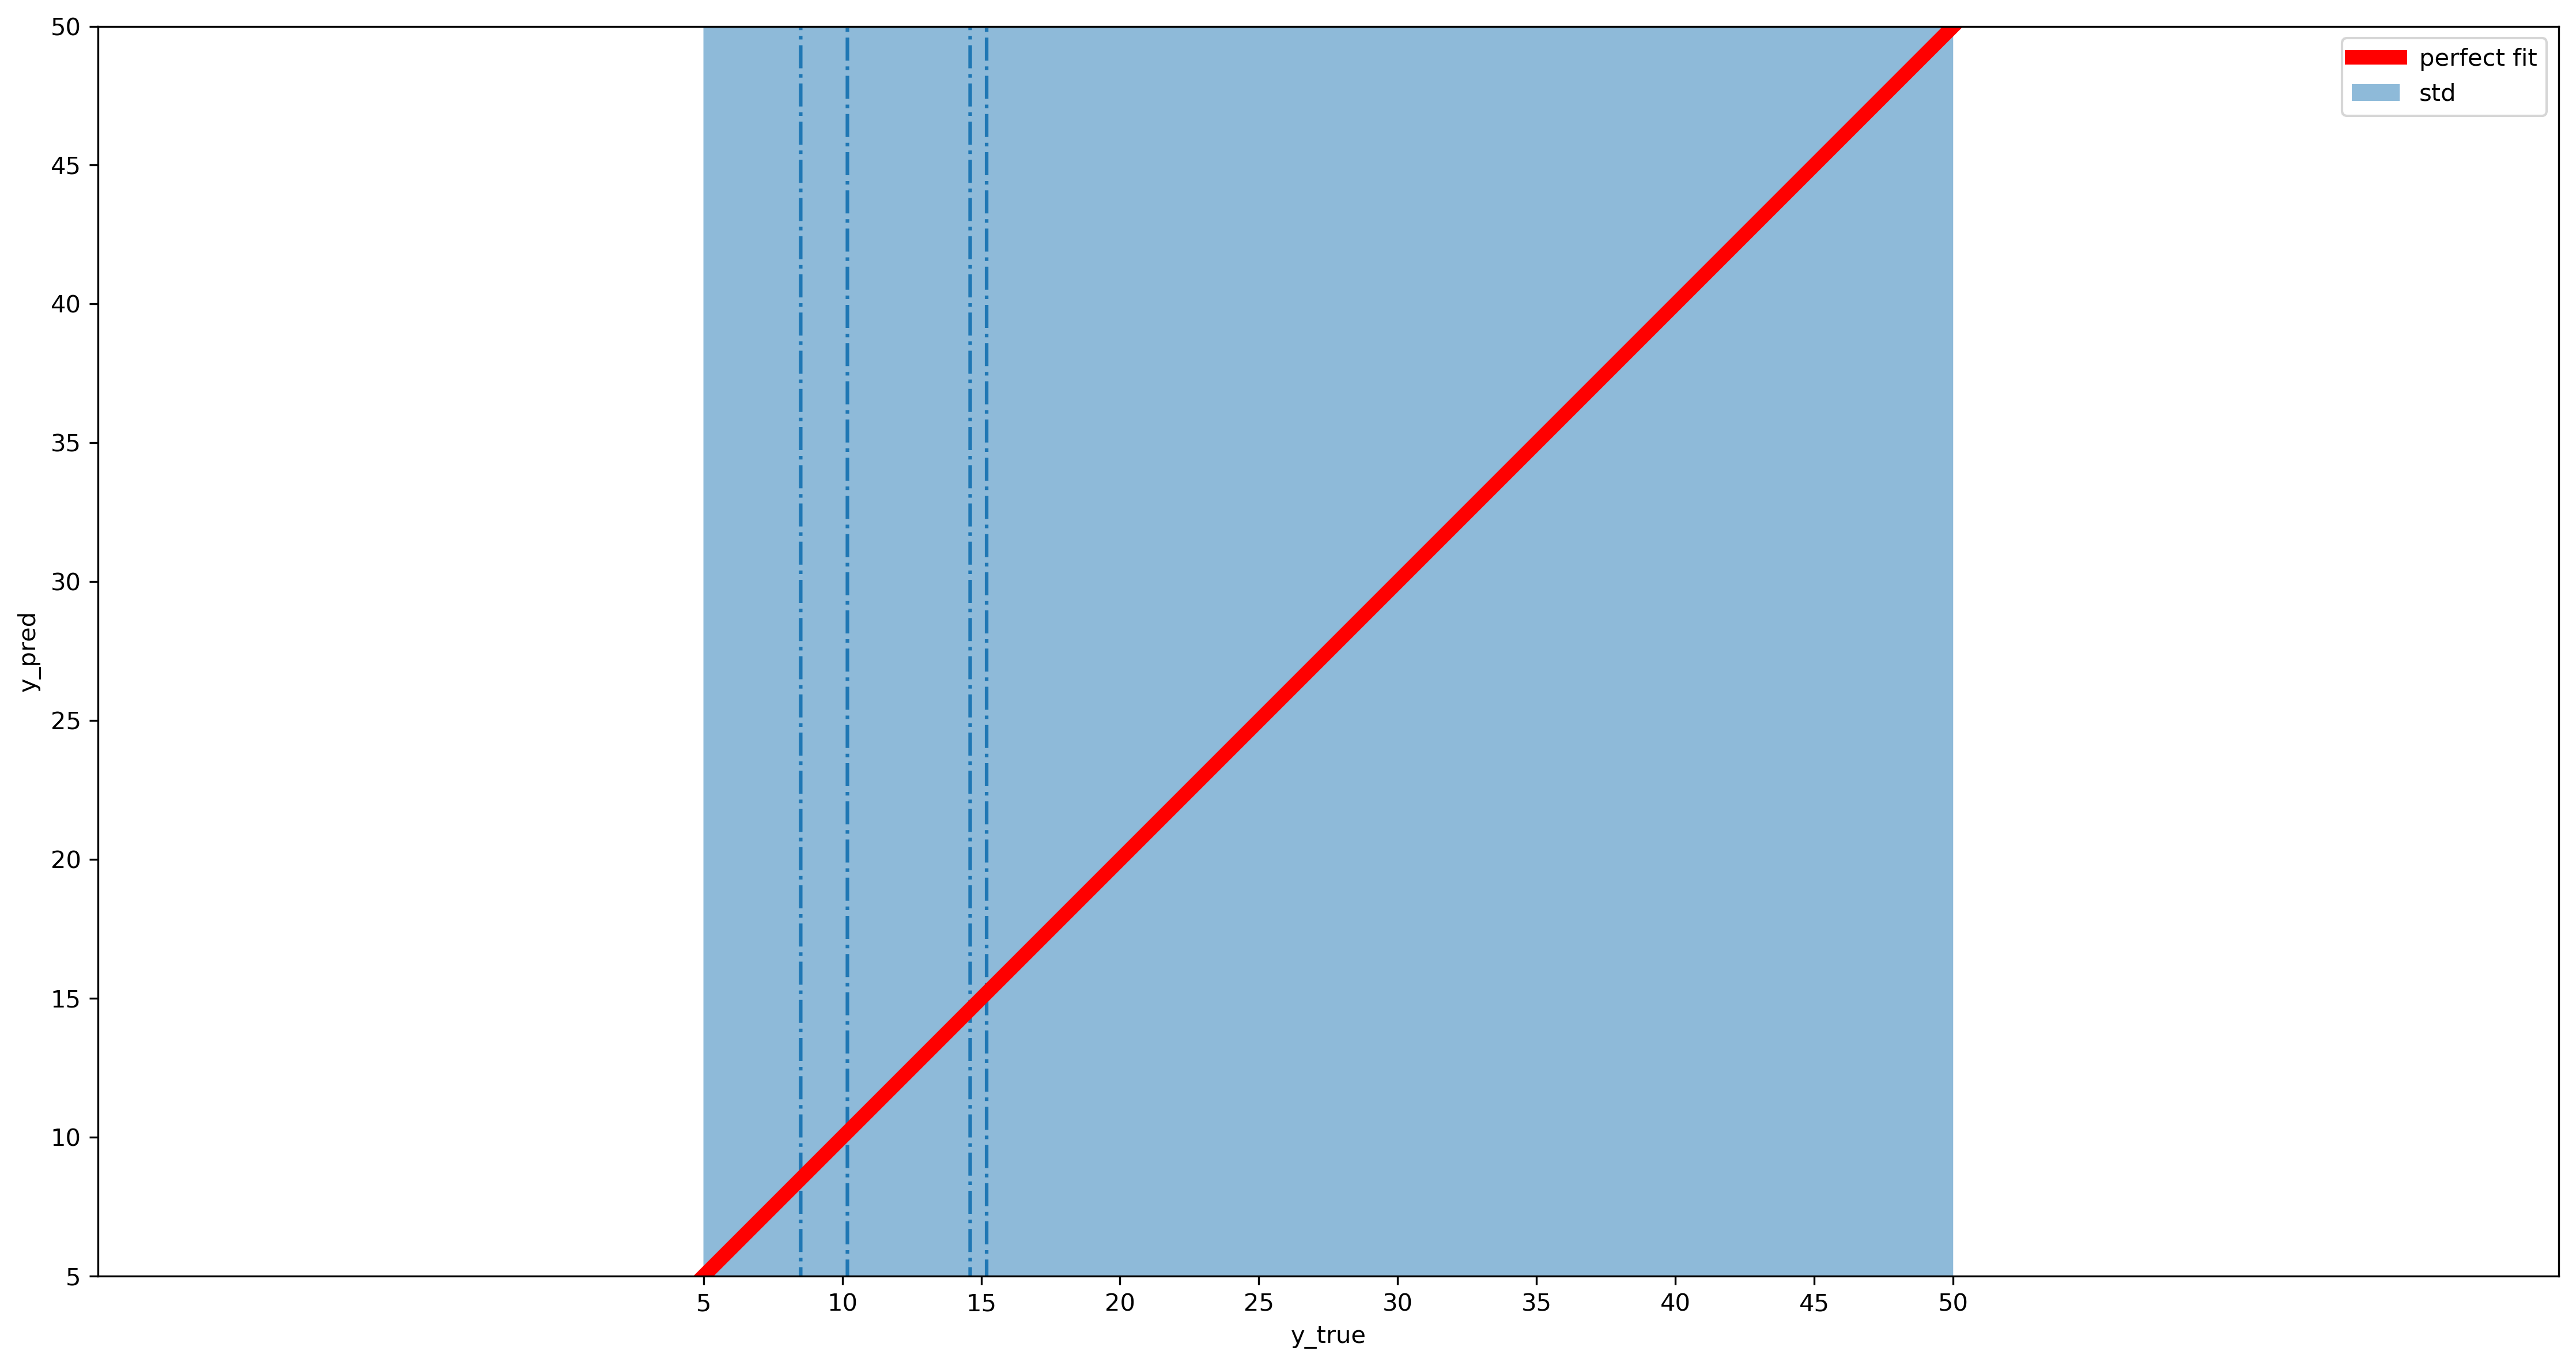

(array([[6.79208e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         3.84970e+02, 2.29800e+01],
        [2.50461e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         3.96900e+02, 2.67700e+01],
        [4.57461e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         8.82700e+01, 3.69800e+01],
        ...,
        [1.83377e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
         3.89610e+02, 1.92000e+00],
        [1.38100e-02, 8.00000e+01, 4.60000e-01, ..., 1.44000e+01,
         3.94230e+02, 2.97000e+00],
        [5.78340e-01, 2.00000e+01, 3.97000e+00, ..., 1.30000e+01,
         3.84540e+02, 7.44000e+00]], dtype=float32),
 array([ 5. ,  5.6,  7. ,  7.2,  7.2,  8.5,  8.8, 10.2, 10.5, 11.3, 11.7,
        11.7, 11.9, 12.6, 12.7, 13.1, 13.2, 13.3, 13.5, 13.8, 13.8, 14.6,
        15. , 15.2, 15.2, 15.4, 15.6, 16.2, 17.2, 17.3, 17.5, 17.8, 17.8,
        18.5, 18.7, 18.8, 18.9, 18.9, 19.1, 19.4, 19.4, 19.6, 19.6, 20.1,
        20.2, 20.4, 20.6, 20.6, 20.6, 20.8, 20.8, 21.1, 21.2, 

In [10]:
plot_pred_to_true(model, dataset)